In [1]:
# Import necessary modules
from dataguy.core import DataGuy
import pandas as pd
import numpy as np

# Create a sample DataGuy instance
data_guy = DataGuy()

In [2]:
import importlib
from dataguy import core
importlib.reload(core)
from dataguy.core import DataGuy
data_guy = DataGuy()

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from claudette import Chat, models
import re


In [2]:
import builtins
import types

# Updated ContextManager for notebook: only show user‐relevant imports & variables
class ContextManager:
    def __init__(self, max_code_history=100):
        self.imported_packages = set()
        self.variables = {}
        self.code_history = []
        self.max_code_history = max_code_history
    
    def update_from_globals(self, globals_dict):
        # Reset trackers
        self.imported_packages.clear()
        self.variables.clear()
        
        # Track non‐private module imports
        for name, obj in globals_dict.items():
            if isinstance(obj, types.ModuleType) and not name.startswith('_'):
                self.imported_packages.add(name)
        
        # Track only meaningful variables
        for name, obj in globals_dict.items():
            if (
                name.startswith('_') or
                name in builtins.__dict__ or
                isinstance(obj, types.ModuleType) or
                callable(obj)
            ):
                continue
            # Keep DataFrame, ndarray, list, dict, primitives
            if isinstance(obj, (pd.DataFrame, np.ndarray, list, dict, int, float, str, bool)):
                t = type(obj).__name__
                if hasattr(obj, 'shape'):
                    self.variables[name] = f"{t}{obj.shape}"
                else:
                    self.variables[name] = t
    
    def add_code(self, code):
        lines = code.strip().split('\n')
        self.code_history.extend(lines)
        if len(self.code_history) > self.max_code_history:
            self.code_history = self.code_history[-self.max_code_history:]
    
    def get_context_summary(self):
        lines = ["# CONTEXT", ""]
        # Imports
        lines.append("## Imports")
        lines.append(", ".join(sorted(self.imported_packages)) or "None")
        # Variables
        lines.append("\n## Variables")
        if self.variables:
            for k, v in sorted(self.variables.items()):
                lines.append(f"- {k}: {v}")
        else:
            lines.append("None")
        # Code history
        lines.append("\n## Code History")
        if self.code_history:
            lines.append("```python")
            lines.extend(self.code_history)
            lines.append("```")
        else:
            lines.append("None")
        return "\n".join(lines)


In [13]:
# %%
# Updated helper to return only relevant namespace items, excluding __builtins__

import re

def run_llm_code(chat, context, data, task):
    prompt = context.get_context_summary() + "\n# Task: " + task
    resp = chat(prompt)
    raw = resp.content[0].text
    
    # Extract code block
    match = re.search(r'```(?:python)?\n(.*?)```', raw, re.S)
    code = match.group(1).strip() if match else raw.strip()
    
    # Print only the code
    print(code)
    
    # Prepare base namespace
    ns = {'pd': pd, 'np': np, 'data': data, 'plt': plt}
    base_keys = set(ns.keys())
    
    # Execute LLM code
    exec(code, ns)
    
    # Update context
    context.add_code(code)
    context.update_from_globals(ns)
    
    # Determine new or updated items
    diff_keys = set(ns.keys()) - base_keys
    # Always include 'data' and exclude private keys
    relevant_keys = {'data'} | {k for k in diff_keys if not k.startswith('_')}
    
    # Build filtered namespace without __builtins__
    filtered_ns = {k: ns[k] for k in relevant_keys}
    return filtered_ns


In [4]:
# %%
# Initialize chat and context
chat = Chat(models[-1], sp="You are a Python data assistant. Only respond with code. Do not add any explanations or comments. The code will be run.")
ctx = ContextManager()


In [35]:
chat_plot = Chat(models[2], sp="You are a Python data assistant. Only respond with code. Do not add any explanations or comments. The code will be run.")


In [5]:
chat_language = Chat(models[-1], sp="You are a Python data assistant. You are concise and to the point, without any preamble. Do not write code.")

In [6]:
# %%
# 1) Prepare raw data (static)
data = pd.DataFrame({'A': [1, 2, None, 4], 'B': [5, None, 7, 8]})
ctx.update_from_globals(globals())
data


,A,B
0,1.0,5.0
1,2.0,NaN
2,NaN,7.0
3,4.0,8.0


In [7]:
def summarize_data(data):
    """
    Return a summary dict with:
      - shape
      - columns
      - missing counts per column
      - means per numeric column
    """
    summary = {
        'shape': data.shape,
        'columns': list(data.columns),
        'missing_counts': data.isna().sum().to_dict(),
        'means': data.mean(numeric_only=True).to_dict()
    }
    return summary

In [8]:
# Cell: Define describe_data via LLM
def describe_data(chat, context, data, summary):
    """
    Use LLM to produce a textual description of the dataset.
    """
    # Update context with summary variable
    context.update_from_globals({'summary': summary})
    prompt = (
        context.get_context_summary()
        + "\n# Task: Based on the summary below, describe the dataset in a few sentences.\n"
        + f"Summary: {summary}"
    )
    resp = chat(prompt)
    description = resp.content[0].text
    print(description)
    # update context
    context.add_code(f"# Description: {description}")
    return description

In [9]:
summary = summarize_data(data)
summary

{'shape': (4, 2),
 'columns': ['A', 'B'],
 'missing_counts': {'A': 1, 'B': 1},
 'means': {'A': 2.3333333333333335, 'B': 6.666666666666667}}

In [10]:
import pprint; pprint.pprint(summary)

# Cell: Describe data via LLM
description = describe_data(chat_language, ctx, data, summary)
description

{'columns': ['A', 'B'],
 'means': {'A': 2.3333333333333335, 'B': 6.666666666666667},
 'missing_counts': {'A': 1, 'B': 1},
 'shape': (4, 2)}
The dataset is a small DataFrame with 4 rows and 2 columns (A and B). It contains missing values in both columns (1 missing value each). The mean of column A is approximately 2.33, while the mean of column B is approximately 6.67.


'The dataset is a small DataFrame with 4 rows and 2 columns (A and B). It contains missing values in both columns (1 missing value each). The mean of column A is approximately 2.33, while the mean of column B is approximately 6.67.'

In [14]:
task = (
    "Write a function called 'wrangler' that takes a pandas dataframe and wrangles it for further analysis.\n" 
    "using this summary and description to guide you.\n"
    f"Summary: {summary}\nDescription: {description}"
)
ns = run_llm_code(chat, ctx, data, task)
ns

def wrangler(df):
    # Drop rows with missing values
    df_cleaned = df.dropna()
    
    # Compute mean for each column and fill missing values
    df_filled = df.fillna(df.mean())
    
    return df_filled


{'wrangler': <function wrangler(df)>,
 'data':      A    B
 0  1.0  5.0
 1  2.0  NaN
 2  NaN  7.0
 3  4.0  8.0}

In [15]:
ns

{'wrangler': <function wrangler(df)>,
 'data':      A    B
 0  1.0  5.0
 1  2.0  NaN
 2  NaN  7.0
 3  4.0  8.0}

In [16]:
# Extract the lambda from the namespace
wrangler = ns.get('wrangler')
assert callable(wrangler), "LLM did not produce a callable `wrangler`"

In [17]:
data = wrangler(data)
data

,A,B
0,1.000000,5.000000
1,2.000000,6.666667
2,2.333333,7.000000
3,4.000000,8.000000


In [18]:
# %%
# 1) Read your plot image into bytes
from pathlib import Path

img_path = Path("plot.png")   # ← point this to your uploaded plot file
img_bytes = img_path.read_bytes()


In [23]:
chat_image = Chat(models[2], sp="You are a Python data assistant. You describe images in detail, so it can be reproduced on different data. So details about the data don't matter much.")

In [22]:
# %%
# 2) Ask Claude to describe the plot
# note: chat_image = Chat(models[2], sp="You are a Python data assistant. You describe images in detail, so it can be reproduced.") must already be initialized
resp = chat_image([img_bytes, "This plot will be reproduced in python based on your description. Please describe it in detail."])
description = resp.content[0].text
print("Plot description:\n", description)


Plot description:
 This is a scatter plot showing the relationship between Sepal length (x-axis) and Petal length (y-axis) for three different species of iris flowers. Here are the key details:

1. Axes:
- X-axis: Sepal length (cm), ranging from approximately 4 to 8 cm
- Y-axis: Petal length (cm), ranging from approximately 1 to 7 cm

2. Data points are color-coded by species:
- setosa (pink/coral colored points): clustered at the bottom, petal length around 1-2 cm, sepal length 4-5.5 cm
- versicolor (green points): middle cluster, petal length around 3-5 cm, sepal length 5-7 cm
- virginica (blue points): upper cluster, petal length around 4.5-7 cm, sepal length 5.5-8 cm

3. Plot characteristics:
- White background
- Black axes lines
- Legend positioned on the right side showing "Species" with colored dots for each species
- Points are solid circles of equal size
- No grid lines visible

4. Data distribution shows a clear positive correlation between sepal length and petal length, with

In [40]:
# %%
# 3) Ask Claude to write code that reproduces a similar plot on `data`
import re

plot_task = f"""
# You do not generate image, only code.
# Task: Write Python code using matplotlib (and pandas) to create a plot similar to the one described below,
# applied to the DataFrame variable `data` in our session.
# Description of original plot:
{description}
"""
resp2 = chat_plot(prompt)
resp2



```python
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,6))
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

colors = {'setosa':'coral', 'versicolor':'green', 'virginica':'blue'}
for species in colors:
    subset = data[data['species'] == species]
    ax.scatter(subset['sepal_length'], subset['petal_length'], 
              c=colors[species], label=species, s=50)

ax.set_xlabel('Sepal length (cm)')
ax.set_ylabel('Petal length (cm)')
ax.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xlim(4, 8)
ax.set_ylim(1, 7)
ax.grid(False)

plt.tight_layout()
plt.show()
```

<details>

- id: `msg_014Eo3z9ZM4Cz9omrxHFjHUg`
- content: `[{'citations': None, 'text': "```python\nimport matplotlib.pyplot as plt\n\nfig, ax = plt.subplots(figsize=(8,6))\nax.set_facecolor('white')\nfig.patch.set_facecolor('white')\n\ncolors = {'setosa':'coral', 'versicolor':'green', 'virginica':'blue'}\nfor species in colors:\n    subset = data[data['species'] == species]\n    ax.scatter(subset['sepal_length'], subset['petal_length'], \n              c=colors[species], label=species, s=50)\n\nax.set_xlabel('Sepal length (cm)')\nax.set_ylabel('Petal length (cm)')\nax.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')\n\nax.set_xlim(4, 8)\nax.set_ylim(1, 7)\nax.grid(False)\n\nplt.tight_layout()\nplt.show()\n```", 'type': 'text'}]`
- model: `claude-3-5-sonnet-20241022`
- role: `assistant`
- stop_reason: `end_turn`
- stop_sequence: `None`
- type: `message`
- usage: `{'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 979, 'output_tokens': 236}`

</details>

In [39]:
resp2.content[0].text

"```python\nimport matplotlib.pyplot as plt\n\nplt.figure(figsize=(8,6))\n\ncolors = {'setosa':'coral', 'versicolor':'green', 'virginica':'blue'}\nfor species in colors:\n    subset = data[data['species'] == species]\n    plt.scatter(subset['sepal_length'], subset['petal_length'], \n                c=colors[species], label=species)\n\nplt.xlabel('Sepal length (cm)')\nplt.ylabel('Petal length (cm)') \nplt.legend(title='Species')\n\nplt.xlim(4, 8)\nplt.ylim(1, 7)\n\nplt.show()\n```"

plt.figure(figsize=(8,6))
plt.scatter(data['A'], data['B'], color='blue', s=50)
plt.xlabel('A')
plt.ylabel('B')
plt.xlim(0, max(data['A'])*1.1)
plt.ylim(0, max(data['B'])*1.1)
plt.grid(False)
plt.show()


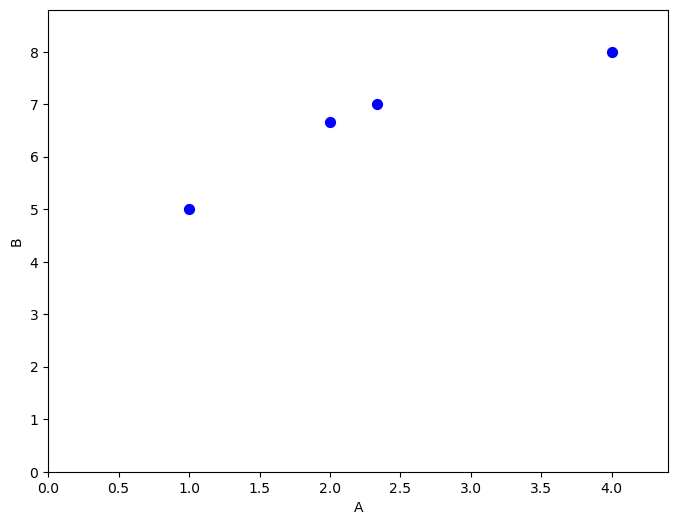

{'data':           A         B
 0  1.000000  5.000000
 1  2.000000  6.666667
 2  2.333333  7.000000
 3  4.000000  8.000000}

In [41]:
ns = run_llm_code(chat_plot, ctx, data, plot_task)
ns
